# Introduction To TensorRT

## What is TensorRT?
TensorRT is an optimization SDK created by Nvidia corp to enable optimal performance tailoring to Nvidia's different GPGPU (General Perpose GPU's) serieses.

TensorRT is post training optimization, that means that after the selected architecture is trained, TensorRT receives the model description and weights and optimizes the model graph to perform the inference faster and with smaller footprint on specific target platform.
<br><br><img src="images/tensorrt-overview.png" height="30%" width="30%"/><br><br>

TensorRT has SDK in C++ and Python.

TensorRT accepts as an input model description and weights, and performs different optimizations to the model:<br>
1. Reduce Mixed Precision - maximizes throughput by **quantizing** models to **FP16 & INT8(With Calibration)** while preserving accuracy<br>
2. Layer and Tensor Fusion - optimizes use of GPU memory and bandwidth by fusing nodes in a kernel<br>
3. Kernel Auto-Tuning - selects best data layers and algorithms based on the target GPU platform<br>
4. Dynamic Tensor Memory - minimizes memory footprint and reuses memory for tensors efficiently<br>
5. Multi-Stream Execution - uses a scalable design to process multiple input streams in parallel<br>
6. Time Fusion - optimizes recurrent neural networks over time steps with dynamically generated kernels<br>
<br>
<br>

TensorRT supports compilation to highly efficient execution of verity of different DNN functions, one can also specify parts of the graph that should not optimize (mostly done when a function is not supported by TensorRT conversion - in newer versions ignores on its on)
<br><br><img src="images/tensorrt-graph-optimization.png" height="60%" width="60%"/><br><br>

> Note: The generated plan files are not portable across platforms or TensorRT versions, and are specific to the exact GPU model they were built on.
<br><br>

To describe the network to TensorRT we have few options:
* Describe the network architecture explicitly and convert weights to descriptor with Python & C++ API
* Integration with existing deep learning frameworks (TF-TRT[tensorflow], caffe)
* Using TensorRT ONNX parser load ONNX descriptor (possibly generated from DL framework)
<br><br><img src="images/tensorrt-onnx-parser.png"/>


In the following sessions we will work with TF-TRT, a tensorflow wrapper around TensorRT, the method of operation is the following:
<br><br><img src="images/tensorrt-workflow.png" height="60%" width="60%"/><br><br>

> Note: its also possible to serialize the model and deserialize it in C++ tensorrt API or TensorRT Inference Server, thus allow not using tensorflow for inference at all.



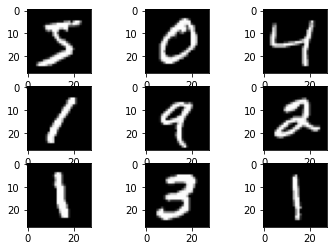

In [31]:
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
import multiprocessing
import time

def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


train_images, train_labels, validation_images, validation_labels = load_dataset()

# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(train_images[i], cmap=pyplot.get_cmap('gray'))


# show the figure
pyplot.show()


to_categorical - function that takes vector input with the size of number of classes where the selected class index is 1 and returns the number of class (index of 1 in the vector), we do this because the loss function of the model is CategoricalCrossEntropy which calculates loss between the most likely prediction (after softmax) to the ground truth (more efficient because in the back propegation only the ground truth 1 value get back propegated)
<br><br>
## Dataset Preprocessing
Convert each pixel to float32 with normalized value from(0-1)

In [32]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


train_images, validation_images = prep_pixels(train_images, validation_images)
print("Done converting to float32 normalized values")

Done converting to float32 normalized values


## Create and Train The Model
As a rule of thumb MSE (mean squere error, L2 Loss) is more suitable as a loss function to regression problems and CrossEntropy is more relevant for classification problems
Binary cross entropy is more suitable for binning the different classifications in the data, MSE is better for regression as it is more tolerrant for close values.

In [9]:
def create_model_and_train( ):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    model.fit(train_images, train_labels, epochs=2)
    
    test_loss, test_acc = model.evaluate(validation_images, validation_labels, verbose=2)

    print('\nTest accuracy:', test_acc)

    model.save('./saved_model')

# We are running training in a sepperate process so we can close it and free resources when done training
p = multiprocessing.Process(target=create_model_and_train)
p.start()
p.join()

2022-04-26 10:58:49.989961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 10:58:50.050485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 10:58:50.050919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 10:58:50.052535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 10:58:50.052970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Epoch 1/2


2022-04-26 10:58:51.427806: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2022-04-26 10:58:51.580259: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 10:58:52.888383: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


1875/1875 [==============================] - ETA: 1:19:23 - loss: 2.7605 - accuracy: 0.031 - ETA: 2:29 - loss: 2.5196 - accuracy: 0.0625  - ETA: 2:08 - loss: 2.3997 - accuracy: 0.15 - ETA: 1:45 - loss: 2.2026 - accuracy: 0.23 - ETA: 1:42 - loss: 2.1366 - accuracy: 0.27 - ETA: 1:41 - loss: 2.0214 - accuracy: 0.30 - ETA: 1:34 - loss: 1.8142 - accuracy: 0.37 - ETA: 1:29 - loss: 1.6256 - accuracy: 0.44 - ETA: 1:26 - loss: 1.4788 - accuracy: 0.50 - ETA: 1:06 - loss: 1.2870 - accuracy: 0.56 - ETA: 34s - loss: 1.0074 - accuracy: 0.6797 - ETA: 24s - loss: 0.8898 - accuracy: 0.712 - ETA: 20s - loss: 0.7727 - accuracy: 0.751 - ETA: 16s - loss: 0.7142 - accuracy: 0.776 - ETA: 14s - loss: 0.6748 - accuracy: 0.788 - ETA: 12s - loss: 0.6375 - accuracy: 0.800 - ETA: 12s - loss: 0.6144 - accuracy: 0.808 - ETA: 11s - loss: 0.5920 - accuracy: 0.817 - ETA: 10s - loss: 0.5619 - accuracy: 0.825 - ETA: 9s - loss: 0.5395 - accuracy: 0.832 - ETA: 9s - loss: 0.5218 - accuracy: 0.83 - ETA: 8s - loss: 0.5072 - a

2022-04-26 10:59:06.605070: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_model/assets


This network architecture differs from the one in the previous lesson, now we have a convolution layes and pool max layer.<br>

### Convolution Layer - perform convolution with selected kernel size on the input data<br>
<center><img src="images/convolutional.png" height="60%" width="60%"/></center><br>

### Max Pool - down sampling technique with different kernel sizes to control different resolutions<br>

<center><img src="images/max-pool.png" height="60%" width="60%"/><br></center>
<br><br>
> Note: in most of modern implemented optimizers (SGD, ADAM, etc..) there is another parameter used to help minimize the risk for local minimum with low learning rate, **momentum** is the inertia of the optimizer and it is calculated each iteration from the slope of the gardient<br><br>
<center><img src="images/momentum.jpeg" height="45%" width="45%"/><br></center>

## Exercise
### Saved model directory structure
Please perform the training of the model and save it, after saving it explain the structure of the folder (find answer in Google)

In [10]:
!nvidia-smi

Tue Apr 26 11:02:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
import base64

solution = 'U2F2ZWRNb2RlbCBwcm90b2NvbCBidWZmZXINCiogc2F2ZWRfbW9kZWwucGIgb3Igc2F2ZWRfbW9kZWwucGJ0eHQNCiogSW5jbHVkZXMgdGhlIGdyYXBoIGRlZmluaXRpb25zIGFzIE1ldGFHcmFwaERlZiBwcm90b2NvbCBidWZmZXJzLg0KQXNzZXRzDQoqIFN1YmZvbGRlciBjYWxsZWQgYXNzZXRzLg0KKiBDb250YWlucyBhdXhpbGlhcnkgZmlsZXMgc3VjaCBhcyB2b2NhYnVsYXJpZXMsIGV0Yy4NCkV4dHJhIGFzc2V0cw0KKiBTdWJmb2xkZXIgd2hlcmUgaGlnaGVyLWxldmVsIGxpYnJhcmllcyBhbmQgdXNlcnMgY2FuIGFkZCB0aGVpciBvd24gYXNzZXRzIHRoYXQgKiAqIGNvLWV4aXN0IHdpdGggdGhlIG1vZGVsLCBidXQgYXJlIG5vdCBsb2FkZWQgYnkgdGhlIGdyYXBoLg0KKiBUaGlzIHN1YmZvbGRlciBpcyBub3QgbWFuYWdlZCBieSB0aGUgU2F2ZWRNb2RlbCBsaWJyYXJpZXMuDQpWYXJpYWJsZXMNCiogU3ViZm9sZGVyIGNhbGxlZCB2YXJpYWJsZXMuDQoqIHZhcmlhYmxlcy5kYXRhLT8/Pz8/LW9mLT8/Pz8/DQoqIHZhcmlhYmxlcy5pbmRleA=='

base64_bytes = solution.encode('ascii')
message_bytes = base64.b64decode(base64_bytes)
decoded_solution = message_bytes.decode('ascii')

print(decoded_solution)

SavedModel protocol buffer
* saved_model.pb or saved_model.pbtxt
* Includes the graph definitions as MetaGraphDef protocol buffers.
Assets
* Subfolder called assets.
* Contains auxiliary files such as vocabularies, etc.
Extra assets
* Subfolder where higher-level libraries and users can add their own assets that * * co-exist with the model, but are not loaded by the graph.
* This subfolder is not managed by the SavedModel libraries.
Variables
* Subfolder called variables.
* variables.data-?????-of-?????
* variables.index


In [11]:
import subprocess as sp
import os

num_of_iteration = 200

def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

def evaluate_model( ):
    mem_before = get_gpu_memory()[0]
    print("Available GPU Memory before loading: ", mem_before)

    model = tf.keras.models.load_model('./saved_model')
    mem_after = get_gpu_memory()[0]
    print("Available GPU Memory after loading: ", mem_after)

    
    start_time = time.time()
    success = 0
    for i in range(num_of_iteration):
        digit = np.argmax(model.predict(np.asanyarray([validation_images[i]]),), axis=-1)
        if digit[0] == np.argmax(validation_labels[i]):
            success += 1
            

    print("Average FPS: ", num_of_iteration / (time.time() - start_time))
    print("GPU Memory Usage: " + str(mem_before - mem_after) + " MiB")
    print('\nTest accuracy:', float(success) / num_of_iteration)

p = multiprocessing.Process(target=evaluate_model)
p.start()
p.join()

Available GPU Memory before loading:  15109


2022-04-26 11:04:47.822392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:04:47.879180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:04:47.879759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:04:47.881205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:04:47.881721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Available GPU Memory after loading:  1063


2022-04-26 11:04:49.284794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 11:04:50.322829: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


Average FPS:  23.48367168869515
GPU Memory Usage: 14046 MiB

Test accuracy: 0.99


## Exercise
Load the model and measure the inference throughput

In [14]:
def next_number():
    a = 0
    while True:
        a += 1
        yield a
        
gen = next_number()
print(next(gen))
print(next(gen))
print(next(gen))

1
2
3


In [15]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
import random

def optimize_model( ):
    converter = trt.TrtGraphConverterV2(input_saved_model_dir='./saved_model',
                                        conversion_params = tf.experimental.tensorrt.ConversionParams(
                                            precision_mode='FP32',
                                        )
                                       )


    def my_input_fn():
        # Input for a single inference call, for a network that has two input tensors:
        yield (np.asanyarray([train_images[0]]),)


    converter.convert()
    converter.build(my_input_fn)
    converter.save('./optimized')

p = multiprocessing.Process(target=optimize_model)
p.start()
p.join()

INFO:tensorflow:Linked TensorRT version: (8, 0, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 3)


2022-04-26 11:17:22.197123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:17:22.247013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:17:22.247384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:17:22.248414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:17:22.248772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

2022-04-26 11:17:23.419371: I tensorflow/compiler/tf2tensorrt/common/utils.cc:58] Linked TensorRT version: 8.0.3
2022-04-26 11:17:23.420044: I tensorflow/compiler/tf2tensorrt/common/utils.cc:60] Loaded TensorRT version: 8.0.3
2022-04-26 11:17:23.925711: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.
2022-04-26 11:17:24.914658: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger Detected invalid timing cache, setup a local cache instead


INFO:tensorflow:Assets written to: ./optimized/assets


In [21]:
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.framework import convert_to_constants

num_of_iteration = 2000

def get_func_from_saved_model(saved_model_dir):
  saved_model_loaded = tf.saved_model.load(
      saved_model_dir, tags=[tag_constants.SERVING])
  graph_func = saved_model_loaded.signatures[
      signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
  graph_func = convert_to_constants.convert_variables_to_constants_v2(graph_func)
  return graph_func

def evaluate_model( ):
    mem_before = get_gpu_memory()[0]
    print("Available GPU Memory before loading: ", mem_before)

    model_func = get_func_from_saved_model('./optimized')
    mem_after = get_gpu_memory()[0]
    print("Available GPU Memory after loading: ", mem_after)

    success = 0
    start_time = time.time()
    for i in range(num_of_iteration):
        data = tf.convert_to_tensor(np.asanyarray([validation_images[i]]))
        digit = np.argmax(model_func(data), axis=-1)[0]
        if digit == np.argmax(validation_labels[i]):
            success += 1

    print("Average FPS: ", num_of_iteration / float(time.time() - start_time))
    print("GPU Memory Usage: " + str(mem_before - mem_after) + " MiB")
    print('\nTest accuracy:', float(success) / num_of_iteration)

p = multiprocessing.Process(target=evaluate_model)
p.start()
p.join()

Available GPU Memory before loading:  15109


2022-04-26 11:27:40.795972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:40.879579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:40.881315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:40.883759: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:40.884838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Available GPU Memory after loading:  657


2022-04-26 11:27:44.736127: I tensorflow/compiler/tf2tensorrt/common/utils.cc:58] Linked TensorRT version: 8.0.3
2022-04-26 11:27:44.736214: I tensorflow/compiler/tf2tensorrt/common/utils.cc:60] Loaded TensorRT version: 8.0.3
2022-04-26 11:27:44.745518: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.
2022-04-26 11:27:44.790846: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger Detected invalid timing cache, setup a local cache instead


Average FPS:  280.2060373878259
GPU Memory Usage: 14452 MiB

Test accuracy: 0.973


## Exercise
Convert the model with TF-TRT to quntization single-percision and evaluate the model
Can someone explain the suprising result?

In [19]:
def my_calibration_fn():
    counter = 0
    # Input for a single inference call, for a network that has two input tensors:
    while counter < 20:
        yield (np.asanyarray([train_images[counter]]),)
        counter += 1
            
gen = my_calibration_fn()

print(next(gen))
print(next(gen))

(array([[[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
        

In [20]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
import random

def optimize_model( ):
    converter = trt.TrtGraphConverterV2(input_saved_model_dir='./saved_model',
                                        conversion_params = tf.experimental.tensorrt.ConversionParams(
                                            precision_mode='INT8',
                                        )
                                       )

    def my_calibration_fn():
        counter = 0
        # Input for a single inference call, for a network that has two input tensors:
        while counter < 20:
            yield (np.asanyarray([train_images[counter]]),)
            counter += 1


    def my_input_fn():
        # Input for a single inference call, for a network that has two input tensors:
        yield (np.asanyarray([train_images[0]]),)


    converter.convert(my_calibration_fn)
    converter.build(my_input_fn)
    converter.save('./optimized')

p = multiprocessing.Process(target=optimize_model)
p.start()
p.join()

INFO:tensorflow:Linked TensorRT version: (8, 0, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 3)


2022-04-26 11:27:20.618741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:20.669749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:20.670288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:20.671702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:27:20.672304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

2022-04-26 11:27:21.874160: I tensorflow/compiler/tf2tensorrt/common/utils.cc:58] Linked TensorRT version: 8.0.3
2022-04-26 11:27:21.874287: I tensorflow/compiler/tf2tensorrt/common/utils.cc:60] Loaded TensorRT version: 8.0.3
2022-04-26 11:27:22.382147: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger It is suggested to disable layer timing cache while using AlgorithmSelector. Please refer to the developer guide in https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#builder-layer-timing.
2022-04-26 11:27:24.520298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300
2022-04-26 11:27:27.548544: W tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:36] TF-TRT Warning: DefaultLogger Detected invalid timing cache, setup a local cache instead


INFO:tensorflow:Assets written to: ./optimized/assets


https://docs.nvidia.com/deeplearning/tensorrt/best-practices/index.html